In [2]:
library(forecast)
library(car)
library(ggplot2)
#library(zoo)
library(scales)
library(repr)

options(scipen=999)

# Change plot size to 10 x 6
options(repr.plot.width=8, repr.plot.height=5)

jp_data <- read.csv2("korea_employment.csv")
#Remove last row, 2015-01
jp_data <- jp_data[1:nrow(jp_data) - 1,]
jp_data$Date <- as.Date(jp_data$Date, format = "%Y-%m-%d")
#Create column with month value
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
#jp_observed_ts <- zoo(jp_data)

head(jp_data)

,Date,Value,Month
1,2002-01-01,61.66093,01
2,2002-02-01,61.8195,02
3,2002-03-01,62.52377,03
4,2002-04-01,63.69807,04
5,2002-05-01,64.00784,05
6,2002-06-01,64.10573,06


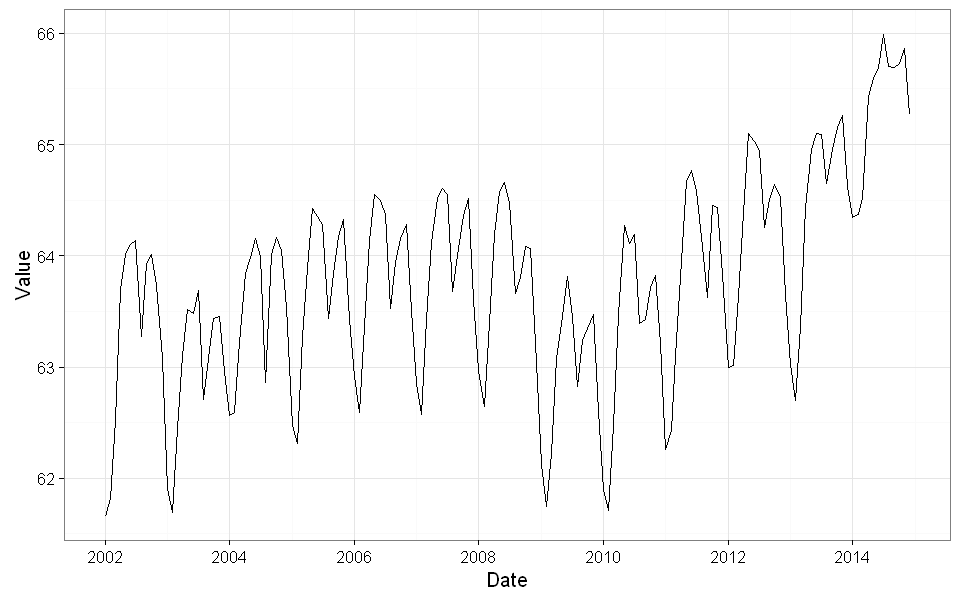

In [3]:
ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = Value)) +
    theme_bw()

Ej stationär, diffa trend (1)

Warning message:
: Removed 1 rows containing missing values (geom_path).

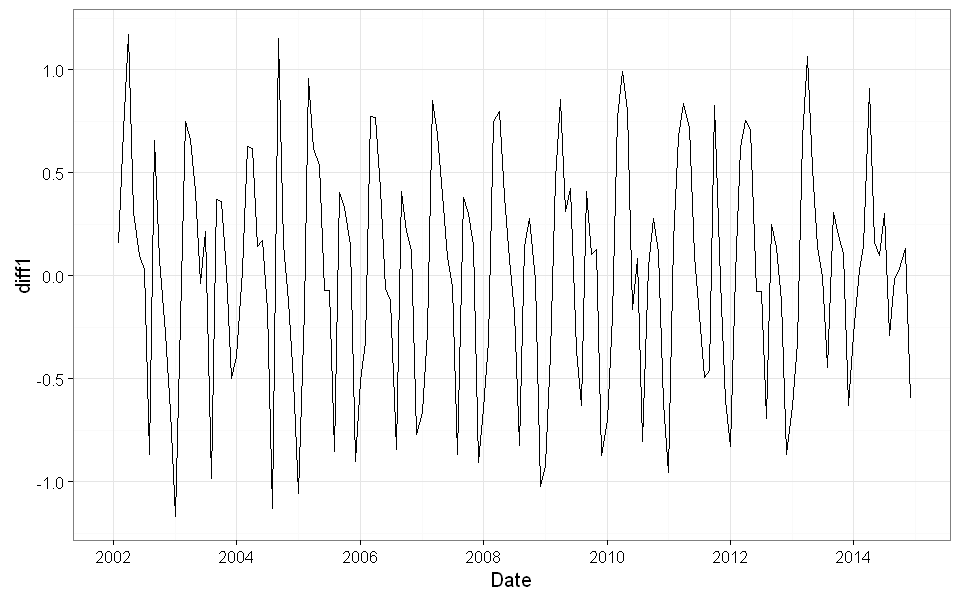

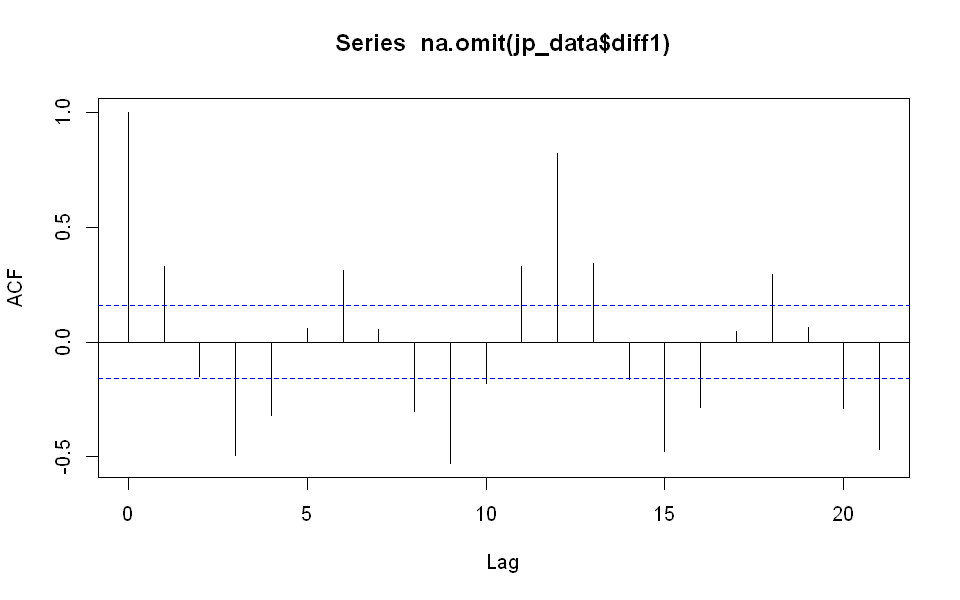

In [18]:
#help(diff)
diff1 <- diff(jp_data$Value, lag = 1)
jp_data$diff1 <- c(NA, diff1)

ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = diff1)) +
    theme_bw()

acf(na.omit(jp_data$diff1))

Ej stationär, diffa säsong (12)

Warning message:
: Removed 13 rows containing missing values (geom_path).

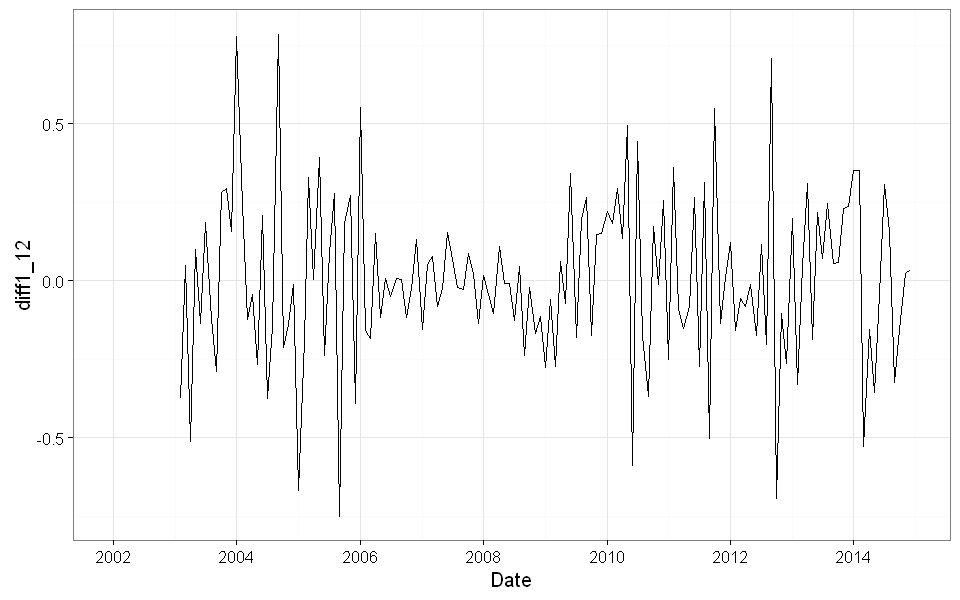

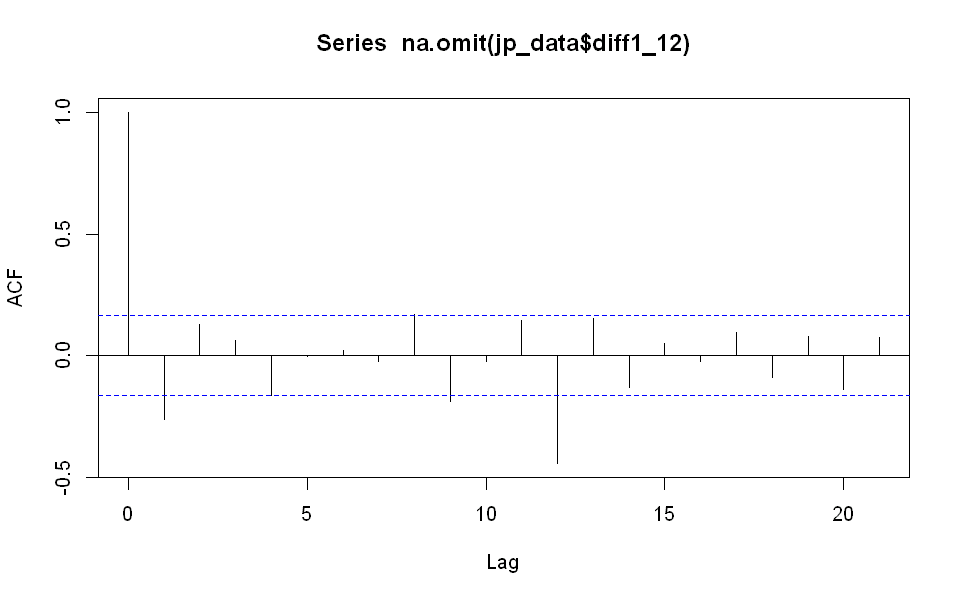

In [24]:
#help(diff)
diff1_12 <- diff(jp_data$diff1, lag = 12)
jp_data$diff1_12 <- c(rep(NA, 12), diff1_12)

ggplot(jp_data, aes(group = 1)) +
    geom_line(aes(x = Date, y = diff1_12)) +
    theme_bw()

acf(na.omit(jp_data$diff1_12))

Stationär ishhh?


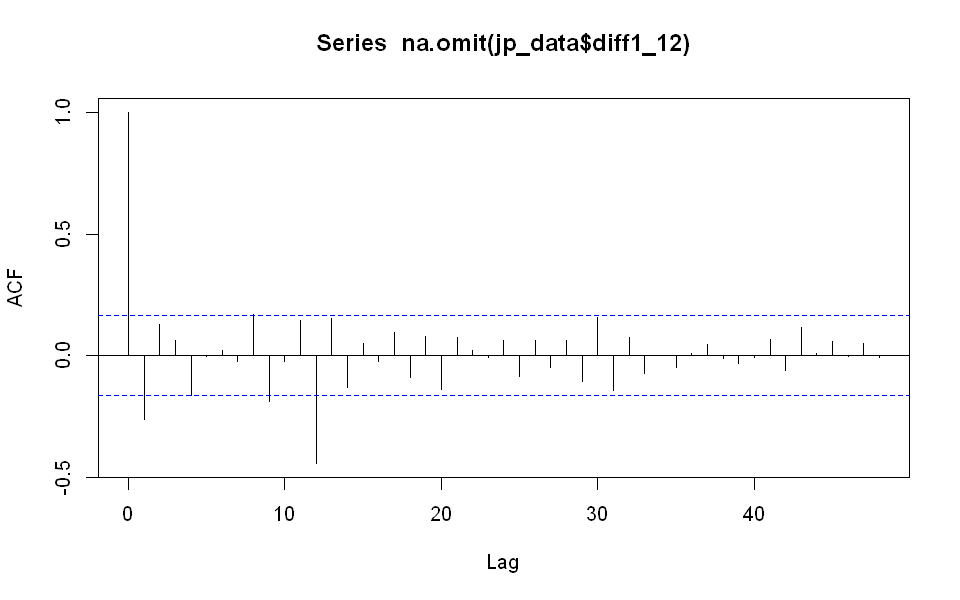

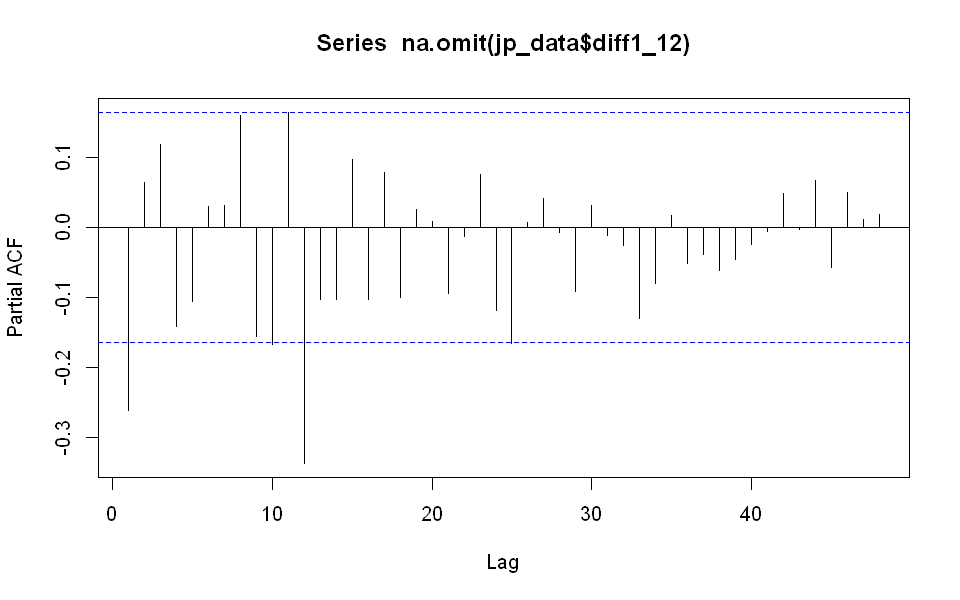

In [25]:
#help(acf)
acf(na.omit(jp_data$diff1_12), lag.max = 48)
pacf(na.omit(jp_data$diff1_12), lag.max = 48)

SARIMA(0,1,0)(3,1,0)

Series: jp_data$Value 
ARIMA(1,1,0)(0,1,1)[12]                    

Coefficients:
          ar1     sma1
      -0.2436  -0.6626
s.e.   0.0816   0.0810

sigma^2 estimated as 0.04734:  log likelihood=13.25
AIC=-20.51   AICc=-20.33   BIC=-11.62

Training set error measures:
                      ME      RMSE       MAE         MPE      MAPE      MASE
Training set 0.003660397 0.2068618 0.1553641 0.005109112 0.2436256 0.3485702
                    ACF1
Training set 0.008518097
[1] "P-values"


ar1                     sma1 
0.0028364126283682011831 0.0000000000000002220446


	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 10.217, df = 8, p-value = 0.2501



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 13.246, df = 20, p-value = 0.8666



	Box-Ljung test

data:  na.omit(residuals(sarima_model))
X-squared = 22.396, df = 32, p-value = 0.8964


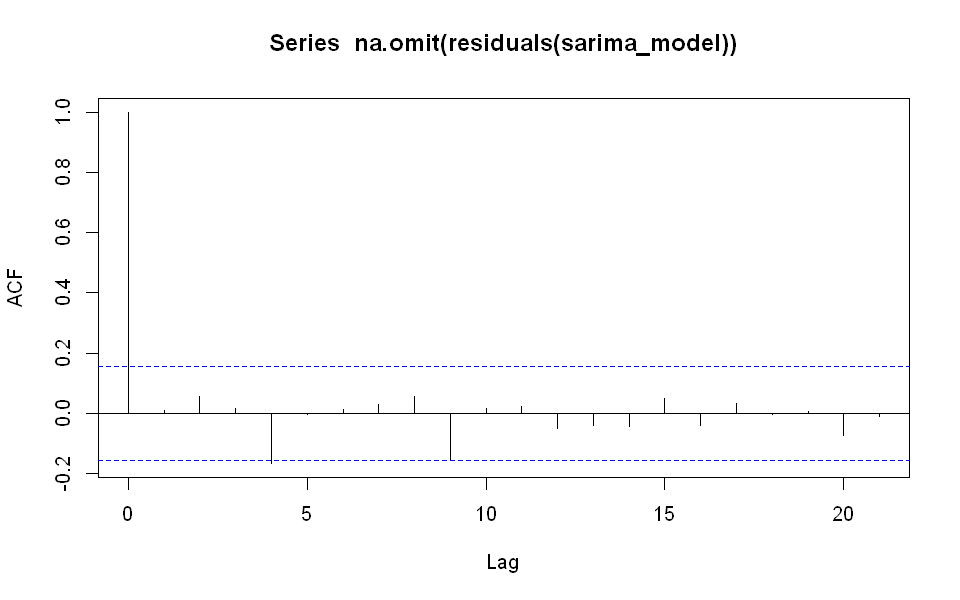

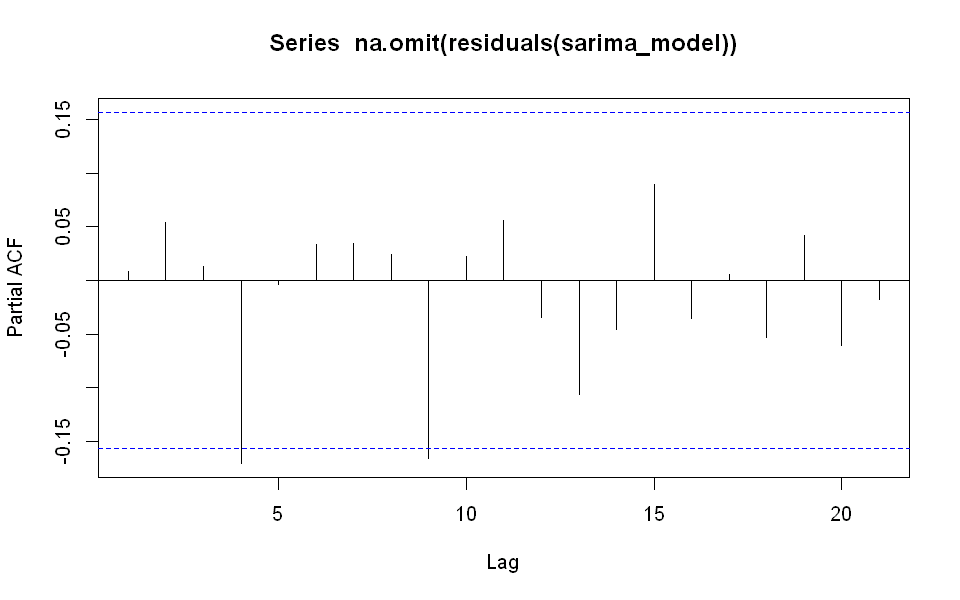

In [31]:
#help(Arima)
sarima_model <- Arima(jp_data$Value, c(1,1,0), seasonal=list(order=c(0,1,1),period=12))

summary(sarima_model)

print("P-values")
(1-pnorm(abs(sarima_model$coef)/sqrt(diag(sarima_model$var.coef))))*2


Box.test(na.omit(residuals(sarima_model)), lag=12, fitdf=4, type="Ljung")
Box.test(na.omit(residuals(sarima_model)), lag=24, fitdf=4, type="Ljung")
Box.test(na.omit(residuals(sarima_model)), lag=36, fitdf=4, type="Ljung")

acf(na.omit(residuals(sarima_model)))
pacf(na.omit(residuals(sarima_model)))

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
157       64.63756 64.35871 64.91641 64.21109 65.06403
158       64.55283 64.20319 64.90248 64.01809 65.08757
159       65.04402 64.62689 65.46115 64.40608 65.68197
160       65.94961 65.47640 66.42282 65.22590 66.67332
161       66.39585 65.87212 66.91958 65.59487 67.19683
162       66.47190 65.90220 67.04160 65.60062 67.34318
163       66.52413 65.91188 67.13637 65.58778 67.46047
164       66.02380 65.37178 66.67581 65.02663 67.02097
165       66.13242 65.44293 66.82192 65.07793 67.18692
166       66.33543 65.61039 67.06047 65.22657 67.44429
167       66.39965 65.64073 67.15858 65.23898 67.56033
168       65.72027 64.92891 66.51163 64.50999 66.93055

Warning message:
: Removed 12 rows containing missing values (geom_path).Warning message:
: Removed 155 rows containing missing values (geom_path).

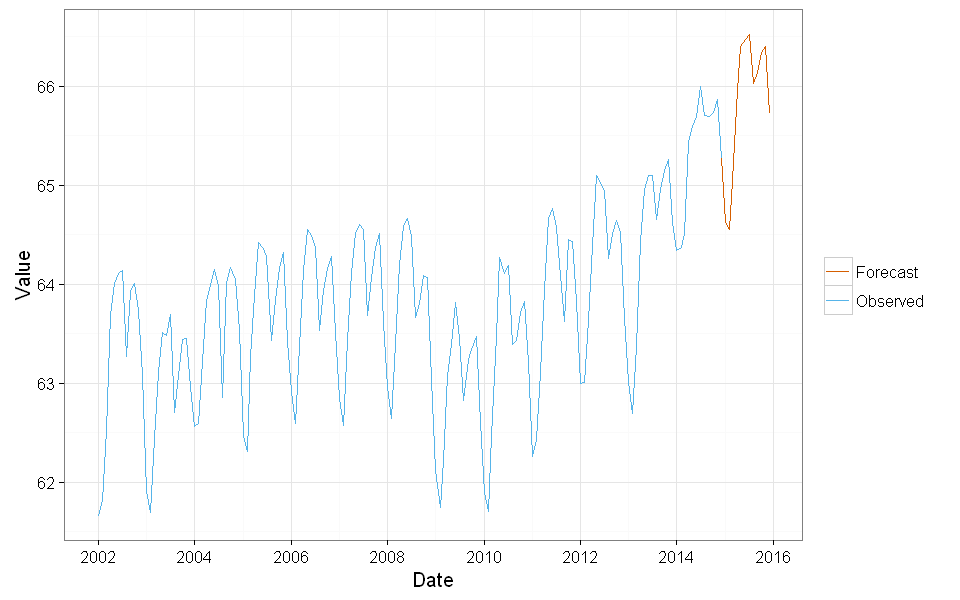

In [34]:
sarima_forecast <- forecast(sarima_model, 12)
sarima_forecast

forecast_mean <- sarima_forecast$mean

predict_data <- data.frame(Date = c(jp_data$Date, seq(as.Date("2015-01-01"), by = "month", length.out = 12)),
                        Value = c(jp_data$Value, rep(NA, 12)),
                        Forecast = c(rep(NA, 155), jp_data[156, 2], forecast_mean))
#predict_data

ggplot(predict_data, aes()) +
    geom_line(aes(x = Date, y = Value, color="Observed")) +
    geom_line(aes(x = Date, y = Forecast, color="Forecast")) +
    scale_colour_manual(name="", values=c(Observed="#56B4E9", Forecast="#D55E00")) +
    theme_bw()